In [1]:
import itertools
import json
import logging
import math
import pathlib
import pickle
import random
import tempfile
from collections import OrderedDict, defaultdict
import random
from sklearn.metrics import accuracy_score
import pandas as pd

#import mir_eval
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import mode as scipy_mode
from sklearn.metrics import average_precision_score, r2_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import glob
import os
#import wandb as wandb_lib
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import itertools as it
from random import sample

import warnings
warnings.simplefilter("ignore", UserWarning)

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Load the data

In [2]:
# Shape of each representation
npy_paths_clmr = sorted(glob.glob('/scratch/cs/sequentialml/datasets/audio-visual/embeddings/features_our/clmr/*.npy'))
npy_paths_musicnn = sorted(glob.glob('/scratch/cs/sequentialml/datasets/audio-visual/embeddings/features_our/musicnn/*.npy'))
npy_paths_jukebox_zeropad = sorted(glob.glob('/scratch/cs/sequentialml/datasets/audio-visual/embeddings/features_our/jukebox_correct/*.npy'))
npy_paths_pann = sorted(glob.glob('/scratch/cs/sequentialml/datasets/audio-visual/embeddings/features_our/pann/*.npy'))

# Feature representations
X_clmr = np.array([np.load(p) for p in npy_paths_clmr])
X_musicnn = np.array([np.load(p) for p in npy_paths_musicnn])
X_jukebox_zeropad = np.array([np.load(p) for p in npy_paths_jukebox_zeropad])
X_pann = np.array([np.load(p) for p in npy_paths_pann])

# Labels
y_clmr = np.array([os.path.split(p)[1].split('-')[0] for p in npy_paths_clmr])
y_musicnn = np.array([os.path.split(p)[1].split('-')[0] for p in npy_paths_musicnn])
y_jukebox_zeropad = np.array([os.path.split(p)[1].split('-')[0] for p in npy_paths_jukebox_zeropad])
y_pann = np.array([os.path.split(p)[1].split('-')[0] for p in npy_paths_pann])

In [3]:
DATASET_TO_ATTRS = {
    "dcase": {
        "num_outputs": 10,
        "output_type": "multiclass",
        "labels": """airport, bus, metro, metro_station, park, public_square, shopping_mall, street_pedestrian, street_traffic, tram""".split(
            ", "
        ),
    }}

PAPER_GRID = {
    "data_standardization": [False, True],
    "hidden_layer_sizes": [[25], [512]],
    "batch_size": [64, 256],
    "learning_rate": [1e-5, 1e-4, 1e-3],
    "dropout_p": [0.25, 0.5, 0.75],
    "l2_weight_decay": [None, 1e-4, 1e-3],
}

num_epochs = 200

In [4]:
allNames = sorted(PAPER_GRID)
combinations = it.product(*(PAPER_GRID[Name] for Name in allNames))

# All possible combinations
#print(list(combinations))
random_search_grids = sample(list(combinations), 15)
random_search_grids

[(64, False, 0.25, [25], 0.0001, 0.001),
 (256, False, 0.5, [512], 0.001, 0.001),
 (256, False, 0.25, [25], None, 0.001),
 (64, True, 0.5, [512], 0.001, 0.0001),
 (64, True, 0.5, [512], 0.0001, 0.0001),
 (256, False, 0.5, [25], None, 0.001),
 (64, True, 0.5, [25], None, 0.001),
 (64, False, 0.5, [512], 0.001, 0.0001),
 (256, True, 0.25, [512], 0.0001, 0.0001),
 (256, False, 0.75, [512], None, 0.001),
 (256, True, 0.5, [512], 0.001, 0.0001),
 (256, False, 0.25, [25], None, 1e-05),
 (64, False, 0.25, [512], 0.001, 1e-05),
 (256, True, 0.75, [25], None, 0.001),
 (256, False, 0.25, [512], None, 0.0001)]

In [5]:
grids = []
for lst_grid in random_search_grids:
    grid = dict()
    batch_size, data_standardization, dropout_p, hidden_layer_sizes, l2_weight_decay, learning_rate = lst_grid[0], lst_grid[1], lst_grid[2], lst_grid[3], lst_grid[4], lst_grid[5]
    grid["batch_size"]= batch_size
    grid["data_standardization"] = data_standardization
    grid["dropout_p"] = dropout_p
    grid["hidden_layer_sizes"] = hidden_layer_sizes
    grid["l2_weight_decay"] = l2_weight_decay
    grid["learning_rate"] = learning_rate
    grids.append(grid)

'''
cfg = {
        "dataset": None,
        "representation": None,
        "data_standardization": True,
        "hidden_layer_sizes": [],
        "batch_size": 64,
        "learning_rate": 1e-3,
        "dropout_input": True,
        "dropout_p": 0.5,
        "l2_weight_decay": None,
        "max_num_epochs": 200,
        "early_stopping_metric": "primary",
        "early_stopping": True,
        "early_stopping_eval_frequency": 8,
        "early_stopping_boredom": 256,
        "seed": 0,
    }
    '''

'\ncfg = {\n        "dataset": None,\n        "representation": None,\n        "data_standardization": True,\n        "hidden_layer_sizes": [],\n        "batch_size": 64,\n        "learning_rate": 1e-3,\n        "dropout_input": True,\n        "dropout_p": 0.5,\n        "l2_weight_decay": None,\n        "max_num_epochs": 200,\n        "early_stopping_metric": "primary",\n        "early_stopping": True,\n        "early_stopping_eval_frequency": 8,\n        "early_stopping_boredom": 256,\n        "seed": 0,\n    }\n    '

In [6]:
cfg = {
        "data_standardization": True,
        "hidden_layer_sizes": [],
        "batch_size": 64,
        "learning_rate": 1e-3,
        "dropout_p": 0.5,
        "l2_weight_decay": None,
        "max_num_epochs": 200,
        "seed": 0,
    }

### Train-validation-test split (70-20-10 ratio)

In [7]:
from sklearn.model_selection import train_test_split

train_ratio = 0.7
test_ratio = 0.2
valid_ratio = 0.1

def split_data(X,y,train_ratio,test_ratio,valid_ratio):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=1-train_ratio, random_state = 42)
    X_valid, X_test, y_valid, y_test = train_test_split(X_test,y_test, test_size=test_ratio/(test_ratio + valid_ratio), random_state=42)
    return X_train, X_test, X_valid, y_train, y_test, y_valid

# Clmr
X_train_clmr, X_test_clmr, X_valid_clmr, y_train_clmr, y_test_clmr, y_valid_clmr = split_data(X_clmr, y_clmr, train_ratio, test_ratio, valid_ratio)
X_train_musicnn, X_test_musicnn, X_valid_musicnn, y_train_musicnn, y_test_musicnn, y_valid_musicnn = split_data(X_musicnn, y_musicnn, train_ratio, test_ratio, valid_ratio)
X_train_jukebox_zeropad, X_test_jukebox_zeropad, X_valid_jukebox_zeropad, y_train_jukebox_zeropad, y_test_jukebox_zeropad, y_valid_jukebox_zeropad = split_data(X_jukebox_zeropad, y_jukebox_zeropad, train_ratio, test_ratio, valid_ratio)
X_train_pann, X_test_pann, X_valid_pann, y_train_pann, y_test_pann, y_valid_pann = split_data(X_pann, y_pann, train_ratio, test_ratio, valid_ratio)

## Check class proportion

In [8]:
def check_equal_class(label):
    assert len(pd.Series(label).unique()) == 10, "Length of the labels should be 10, check again"
    
    print("There are enough classes")

In [9]:
check_equal_class(y_valid_clmr)
check_equal_class(y_valid_musicnn)
check_equal_class(y_valid_jukebox_zeropad)
check_equal_class(y_valid_pann)

There are enough classes
There are enough classes
There are enough classes
There are enough classes


## Check class imbalance

In [10]:
'''
labels = [y_train_clmr, y_train_jukebox_zeropad, y_train_musicnn, y_train_pann]

for df in labels:
    print(pd.Series(df).value_counts())
    print()
'''

'\nlabels = [y_train_clmr, y_train_jukebox_zeropad, y_train_musicnn, y_train_pann]\n\nfor df in labels:\n    print(pd.Series(df).value_counts())\n    print()\n'

In [11]:
split_to_X = defaultdict(lambda: defaultdict(list))
split_to_y = defaultdict(lambda: defaultdict(list))


def split_to_X_y(representation, X_dict, y_dict, X_train, X_valid, X_test, y_train, y_valid, y_test):
    X_dict[representation]["train"] = X_train
    X_dict[representation]["validation"] = X_valid
    X_dict[representation]["test"] = X_test
    y_dict[representation]["train"] = y_train
    y_dict[representation]["validation"] = y_valid
    y_dict[representation]["test"] = y_test
    return X_dict, y_dict

split_to_X, split_to_y = split_to_X_y("clmr", split_to_X, split_to_y, X_train_clmr, X_valid_clmr, X_test_clmr, y_train_clmr, y_valid_clmr, y_test_clmr)
split_to_X, split_to_y = split_to_X_y("musicnn", split_to_X, split_to_y, X_train_musicnn, X_valid_musicnn, X_test_musicnn, y_train_musicnn, y_valid_musicnn, y_test_musicnn)
split_to_X, split_to_y = split_to_X_y("jukebox", split_to_X, split_to_y, X_train_jukebox_zeropad, X_valid_jukebox_zeropad, X_test_jukebox_zeropad, y_train_jukebox_zeropad, y_valid_jukebox_zeropad, y_test_jukebox_zeropad)
split_to_X, split_to_y = split_to_X_y("pann", split_to_X, split_to_y, X_train_pann, X_valid_pann, X_test_pann, y_train_pann, y_valid_pann, y_test_pann)

## Define the Simple Neural Network

In [12]:
class SimpleMLP(nn.Module):
    def __init__(
        self,
        num_features,
        hidden_layer_sizes,
        num_outputs,
        dropout_input=True,
        dropout_p=0.5,
    ):
        super().__init__()
        d = num_features
        self.num_layers = 1
        for i, ld in enumerate(hidden_layer_sizes):
            setattr(self, f"hidden_{i}", nn.Linear(d, ld))
            d = ld
        self.output = nn.Linear(d, num_outputs)
        self.dropout = nn.Dropout(p=dropout_p)
        self.softmax = nn.Softmax()

    def forward(self, x, **kwargs):
        x = self.dropout(x)
        for i in range(self.num_layers):
            x = getattr(self, f"hidden_{i}")(x)
            x = F.relu(x)
            x = self.dropout(x)
        x = self.output(x)
        return x

In [13]:
def optimizer(model, cfg):
    optimizer = torch.optim.Adam(
    model.parameters(),
    lr=cfg["learning_rate"],
    weight_decay=0
    if cfg["l2_weight_decay"] is None
    else cfg["l2_weight_decay"],
)
    return optimizer

In [14]:
def train_valid_loop(X_train, y_train, X_valid, y_valid, model, cfg, std_scaler, label_encod, optim, show_results):
    summarize_frequency = 50
    loss = nn.CrossEntropyLoss()
    epoch = 0
    target_names = label_encod.classes_
    loss_per_epochs = []
    val_loss_per_epochs = []
    accuracy_per_epochs = []
    proba_classes_val = 0
    y_valid_vals = 0
    
    while True:
        ### Training phase ###
        # Put the model into train mode
        model.train()

        # Check if exceeded max num epochs
        if epoch == num_epochs:
            break

        # Create batch
        idxs_train = random.sample(
            list(range(X_train.shape[0])),
            min(cfg["batch_size"], X_train.shape[0]),
        )

        X, y = X_train[idxs_train], y_train[idxs_train]

        X = torch.tensor(X, dtype=torch.float32, device=device)
        y = torch.tensor(y, device=device)

        # Update
        optim.zero_grad()

        y_pred = model(X)
        loss_train = loss(y_pred, y)
        
        loss_per_epochs.append(loss_train.item())

        loss_train.backward()
        optim.step()
        epoch += 1

        ########### Validation phase ###############
        model.eval()
        with torch.no_grad():
            # Create batch
            idxs_val = random.sample(
                list(range(X_valid.shape[0])),
                min(cfg["batch_size"], X_valid.shape[0]),
            )
            X_valid, y_valid = X_valid[idxs_val], y_valid[idxs_val]

            X_valid = torch.tensor(X_valid, dtype=torch.float32, device=device)
            y_valid = torch.tensor(y_valid, device=device)

            y_pred_valid = model(X_valid).squeeze()
            
            proba = torch.nn.functional.softmax(y_pred_valid, dim=1)
            #proba_classes_val.extend(proba)

            loss_valid = loss(y_pred_valid, y_valid)

            val_loss_per_epochs.append(loss_valid.item())

            y_pred_labels = []
            for tensor in y_pred_valid:
                pred = torch.argmax(tensor)
                y_pred_labels.append(pred)

            acc_valid = accuracy_score(y_valid, y_pred_labels)
            accuracy_per_epochs.append(acc_valid)
            
            proba_classes_val = proba
            y_valid_vals = y_valid
            
            if show_results:
                # Summarize
                if epoch % summarize_frequency == 0:
                    loss_train = loss_train.item()
                    loss_valid = loss_valid.item()
                    print("Epoch {}, train_loss: {}, valid_loss: {}".format(epoch, loss_train, loss_valid))
                    print(classification_report(y_valid, y_pred_labels, target_names=target_names))
                    plot_rocauc(proba, y_valid)

    return loss_per_epochs, val_loss_per_epochs, accuracy_per_epochs, proba_classes_val, y_valid_vals

In [17]:
## ROCAUC plot
def plot_rocauc(proba_pred, y_true):
    proba = np.array([i.numpy() for i in proba_pred])

    lb = preprocessing.LabelBinarizer()
    lb.fit(y_true)
    y_valid_auc = lb.transform(y_true)


    #Compute ROC curve and ROC area for each class 
    fpr = dict() 
    tpr = dict() 
    roc_auc = dict() 
    n_classes = 10


    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_valid_auc[:, i], proba[:, i]) 
        roc_auc[i] = auc(fpr[i], tpr[i]) 
        
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))  # roc_auc_score
        
    plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)
    plt.plot([0, 1], [0, 1], 'k--')
    # plt.grid()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [18]:
def plot_losses(train_losses, valid_losses, acc):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,15))
    axes[0].plot(train_losses)
    axes[1].plot(valid_losses)
    axes[0].set_title("Train losses")
    axes[1].set_title("Valid losses")
    
    axes[2].plot(acc)
    axes[2].set_title("Accuracy")
    plt.show()

In [19]:
scaler_dict = {}
le_dict = {}

## Clmr

In [20]:
best_val_acc_clmr = 0
best_grid_clmr = 0
best_valid_clmr = 0
best_y_proba_clmr = 0
best_idxs_clmr = 0

for grid in grids:
    print("Starting grid...")
    # Standard scaler
    std_scaler_clmr = StandardScaler(with_mean=grid["data_standardization"], with_std=grid["data_standardization"])
    #std_scaler_clmr = StandardScaler()
    X_train_clmr = std_scaler_clmr.fit_transform(split_to_X["clmr"]["train"])
    X_valid_clmr = std_scaler_clmr.fit_transform(split_to_X["clmr"]["validation"])

    scaler_dict["clmr"] = std_scaler_clmr

    # Label encoding
    le_clmr = preprocessing.LabelEncoder()
    y_train_clmr = le_clmr.fit_transform(split_to_y["clmr"]["train"])
    y_valid_clmr = le_clmr.fit_transform(split_to_y["clmr"]["validation"])

    le_dict["clmr"] = le_clmr

    probe_clmr = SimpleMLP(
                num_features = split_to_X["clmr"]["train"].shape[1],
                hidden_layer_sizes = grid["hidden_layer_sizes"],
                num_outputs = DATASET_TO_ATTRS["dcase"]["num_outputs"],
                dropout_input=True,
                dropout_p=grid["dropout_p"])

    probe_clmr.to(device)

    # Create optimizer
    optimizer_clmr = optimizer(probe_clmr, grid)        
    
    train_losses, val_losses, acc_epochs, proba_classes_val_clmr, y_valid_vals_clmr = train_valid_loop(X_train_clmr, y_train_clmr, X_valid_clmr, y_valid_clmr, probe_clmr, grid, std_scaler_clmr, le_clmr, optimizer_clmr, show_results=False)
    #plot_losses(train_losses, val_losses, acc_epochs)
    
    mean_val_acc = np.mean(acc_epochs)
    print("Grid {} - validation accuracy: {}".format(grid, mean_val_acc))
    print()
    if mean_val_acc >= best_val_acc_clmr:
        best_val_acc_clmr = mean_val_acc
        best_grid_clmr = grid
        best_valid_clmr = acc_epochs
        best_y_proba_clmr = proba_classes_val_clmr
        
print("Best grid: {}".format(best_grid_clmr))
print("Best validation accuracy: {}".format(best_val_acc_clmr))

Starting grid...
Grid {'batch_size': 64, 'data_standardization': False, 'dropout_p': 0.25, 'hidden_layer_sizes': [25], 'l2_weight_decay': 0.0001, 'learning_rate': 0.001} - validation accuracy: 0.49609375

Starting grid...
Grid {'batch_size': 256, 'data_standardization': False, 'dropout_p': 0.5, 'hidden_layer_sizes': [512], 'l2_weight_decay': 0.001, 'learning_rate': 0.001} - validation accuracy: 0.59009765625

Starting grid...
Grid {'batch_size': 256, 'data_standardization': False, 'dropout_p': 0.25, 'hidden_layer_sizes': [25], 'l2_weight_decay': None, 'learning_rate': 0.001} - validation accuracy: 0.44416015625

Starting grid...
Grid {'batch_size': 64, 'data_standardization': True, 'dropout_p': 0.5, 'hidden_layer_sizes': [512], 'l2_weight_decay': 0.001, 'learning_rate': 0.0001} - validation accuracy: 0.45765625

Starting grid...
Grid {'batch_size': 64, 'data_standardization': True, 'dropout_p': 0.5, 'hidden_layer_sizes': [512], 'l2_weight_decay': 0.0001, 'learning_rate': 0.0001} - vali

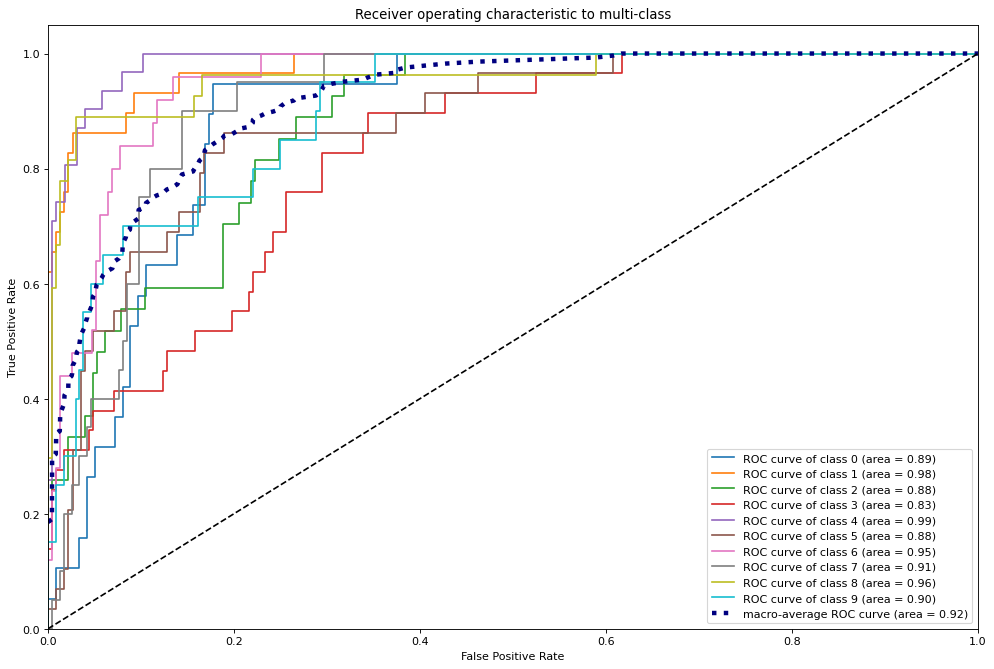

In [21]:
from matplotlib.pyplot import figure
figure(figsize=(15, 10), dpi=80)

plot_rocauc(proba_classes_val_clmr, y_valid_vals_clmr)

## Musicnn

In [22]:
best_val_acc_musicnn = 0
best_grid_musicnn = 0
best_valid_musicnn = 0

for grid in grids:
    print("Starting grid...")

    probe_musicnn = SimpleMLP(
                num_features = split_to_X["musicnn"]["train"].shape[1],
                hidden_layer_sizes = grid["hidden_layer_sizes"],
                num_outputs = DATASET_TO_ATTRS["dcase"]["num_outputs"],
                dropout_input=True,
                dropout_p= grid["dropout_p"],
            )

    probe_musicnn.to(device)

    # Standard scaler
    std_scaler_musicnn = StandardScaler(with_mean=grid["data_standardization"], with_std=grid["data_standardization"])
    X_train_musicnn = std_scaler_musicnn.fit_transform(split_to_X["musicnn"]["train"])
    X_valid_musicnn = std_scaler_musicnn.fit_transform(split_to_X["musicnn"]["validation"])

    scaler_dict["musicnn"] = std_scaler_musicnn

    # Label encoding
    le_musicnn = preprocessing.LabelEncoder()
    y_train_musicnn = le_musicnn.fit_transform(split_to_y["musicnn"]["train"])
    y_valid_musicnn = le_musicnn.fit_transform(split_to_y["musicnn"]["validation"])

    le_dict["musicnn"] = le_musicnn

    # Create optimizer
    optimizer_musicnn = optimizer(probe_musicnn, grid)
    
    train_losses_musicnn, val_losses_musicnn, acc_epochs_musicnn, proba_classes_val_musicnn, y_valid_vals_musicnn = train_valid_loop(X_train_musicnn, y_train_musicnn, X_valid_musicnn, y_valid_musicnn, probe_musicnn, grid, std_scaler_musicnn, le_musicnn, optimizer_musicnn, show_results=False)
    #plot_losses(train_losses_musicnn, val_losses_musicnn, acc_epochs_musicnn)
    
    
    mean_val_acc_musicnn = np.mean(acc_epochs_musicnn)
    print("Grid {} - validation accuracy: {}".format(grid, mean_val_acc_musicnn))
    print()
    if mean_val_acc >= best_val_acc_musicnn:
        best_val_acc_musicnn = mean_val_acc
        best_grid_musicnn = grid
        best_valid_musicnn = acc_epochs_musicnn
        
print("Best grid: {}".format(best_grid_musicnn))
print("Best validation accuracy: {}".format(best_val_acc_musicnn))

Starting grid...
Grid {'batch_size': 64, 'data_standardization': False, 'dropout_p': 0.25, 'hidden_layer_sizes': [25], 'l2_weight_decay': 0.0001, 'learning_rate': 0.001} - validation accuracy: 0.281640625

Starting grid...
Grid {'batch_size': 256, 'data_standardization': False, 'dropout_p': 0.5, 'hidden_layer_sizes': [512], 'l2_weight_decay': 0.001, 'learning_rate': 0.001} - validation accuracy: 0.402890625

Starting grid...
Grid {'batch_size': 256, 'data_standardization': False, 'dropout_p': 0.25, 'hidden_layer_sizes': [25], 'l2_weight_decay': None, 'learning_rate': 0.001} - validation accuracy: 0.2869921875

Starting grid...
Grid {'batch_size': 64, 'data_standardization': True, 'dropout_p': 0.5, 'hidden_layer_sizes': [512], 'l2_weight_decay': 0.001, 'learning_rate': 0.0001} - validation accuracy: 0.42953125

Starting grid...
Grid {'batch_size': 64, 'data_standardization': True, 'dropout_p': 0.5, 'hidden_layer_sizes': [512], 'l2_weight_decay': 0.0001, 'learning_rate': 0.0001} - valida

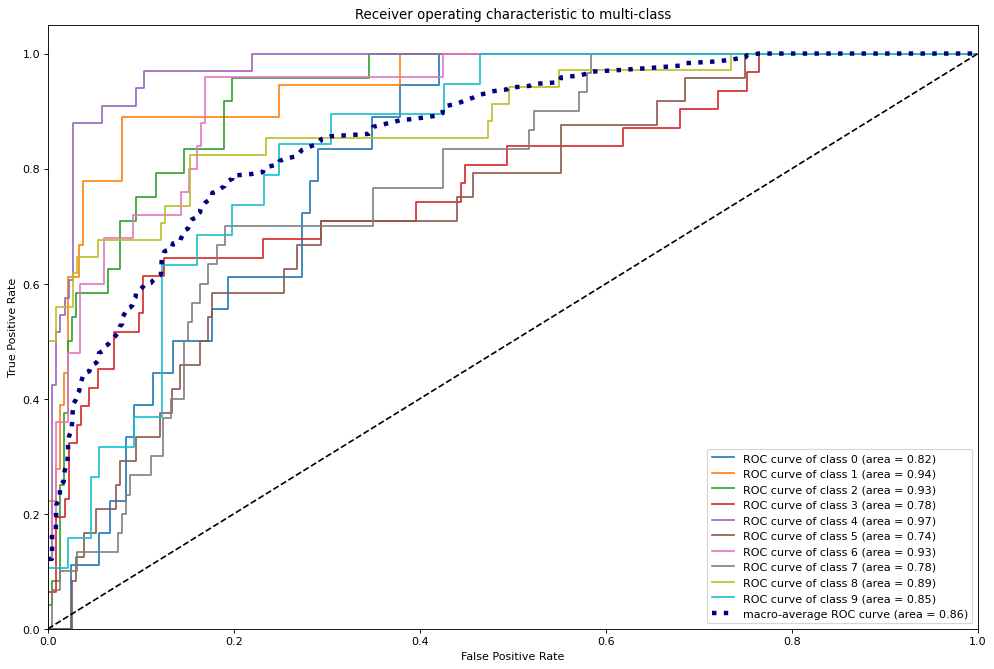

In [23]:
figure(figsize=(15, 10), dpi=80)
plot_rocauc(proba_classes_val_musicnn, y_valid_vals_musicnn)

## Jukebox (0-pad)

In [24]:
best_val_acc_jukebox = 0
best_grid_jukebox = 0
best_valid_jukebox = {}

for grid in grids:
    print("Starting grid...")
    probe_jukebox = SimpleMLP(
                num_features = split_to_X["jukebox"]["train"].shape[1],
                hidden_layer_sizes = [512],
                num_outputs = DATASET_TO_ATTRS["dcase"]["num_outputs"],
                dropout_input=True,
                dropout_p=0.25,
            )

    probe_jukebox.to(device)

    # Standard scaler
    std_scaler_jukebox = StandardScaler()
    X_train_jukebox = std_scaler_jukebox.fit_transform(split_to_X["jukebox"]["train"])
    X_valid_jukebox = std_scaler_jukebox.fit_transform(split_to_X["jukebox"]["validation"])

    scaler_dict["jukebox"] = std_scaler_jukebox

    # Label encoding
    le_jukebox = preprocessing.LabelEncoder()
    y_train_jukebox = le_jukebox.fit_transform(split_to_y["jukebox"]["train"])
    y_valid_jukebox = le_jukebox.fit_transform(split_to_y["jukebox"]["validation"])

    le_dict["jukebox"] = le_jukebox

    # Create optimizer
    optimizer_jukebox = optimizer(probe_jukebox, cfg)
    train_losses_jukebox, val_losses_jukebox, acc_epochs_jukebox, proba_classes_val_jukebox, y_valid_vals_jukebox = train_valid_loop(X_train_jukebox, y_train_jukebox, X_valid_jukebox, y_valid_jukebox, probe_jukebox, cfg, std_scaler_jukebox, le_jukebox, optimizer_jukebox, show_results=False)
    #plot_losses(train_losses_jukebox, val_losses_jukebox, acc_epochs_jukebox)

    
    mean_val_acc_jukebox = np.mean(acc_epochs_jukebox)
    print("Grid {} - validation accuracy: {}".format(grid, mean_val_acc_jukebox))
    print()
    if mean_val_acc_jukebox >= best_val_acc_jukebox:
        best_val_acc_jukebox = mean_val_acc_jukebox
        best_grid_jukebox = grid
        best_valid_jukebox = acc_epochs_jukebox

print("Best grid: {}".format(best_grid_jukebox))
print("Best validation accuracy: {}".format(best_val_acc_jukebox))

Starting grid...
Grid {'batch_size': 64, 'data_standardization': False, 'dropout_p': 0.25, 'hidden_layer_sizes': [25], 'l2_weight_decay': 0.0001, 'learning_rate': 0.001} - validation accuracy: 0.769921875

Starting grid...
Grid {'batch_size': 256, 'data_standardization': False, 'dropout_p': 0.5, 'hidden_layer_sizes': [512], 'l2_weight_decay': 0.001, 'learning_rate': 0.001} - validation accuracy: 0.765703125

Starting grid...
Grid {'batch_size': 256, 'data_standardization': False, 'dropout_p': 0.25, 'hidden_layer_sizes': [25], 'l2_weight_decay': None, 'learning_rate': 0.001} - validation accuracy: 0.7346875

Starting grid...
Grid {'batch_size': 64, 'data_standardization': True, 'dropout_p': 0.5, 'hidden_layer_sizes': [512], 'l2_weight_decay': 0.001, 'learning_rate': 0.0001} - validation accuracy: 0.695078125

Starting grid...
Grid {'batch_size': 64, 'data_standardization': True, 'dropout_p': 0.5, 'hidden_layer_sizes': [512], 'l2_weight_decay': 0.0001, 'learning_rate': 0.0001} - validati

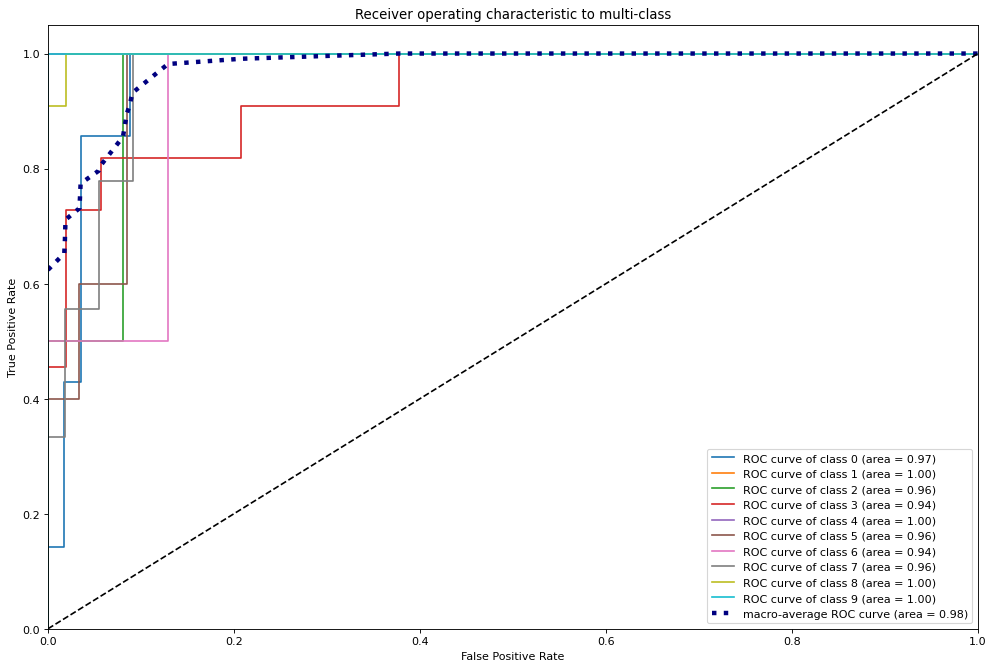

In [25]:
figure(figsize=(15, 10), dpi=80)
plot_rocauc(proba_classes_val_jukebox, y_valid_vals_jukebox)

## PANN

In [26]:
best_val_acc_pann = 0
best_grid_pann = 0
best_valid_pann = {}

for grid in grids:
    probe_pann = SimpleMLP(
                num_features = split_to_X["pann"]["train"].shape[1],
                hidden_layer_sizes = [512],
                num_outputs = DATASET_TO_ATTRS["dcase"]["num_outputs"],
                dropout_input=True,
                dropout_p=0.25,
            )

    probe_pann.to(device)

    # Standard scaler
    std_scaler_pann = StandardScaler()
    X_train_pann = std_scaler_pann.fit_transform(split_to_X["pann"]["train"])
    X_valid_pann = std_scaler_pann.fit_transform(split_to_X["pann"]["validation"])

    scaler_dict["pann"] = std_scaler_pann

    # Label encoding
    le_pann = preprocessing.LabelEncoder()
    y_train_pann = le_pann.fit_transform(split_to_y["pann"]["train"])
    y_valid_pann = le_pann.fit_transform(split_to_y["pann"]["validation"])

    le_dict["pann"] = le_pann
    # Create optimizer
    optimizer_pann = optimizer(probe_pann, cfg)

    train_losses_pann, val_losses_pann, acc_epochs_pann, proba_classes_val_pann, y_valid_vals_pann = train_valid_loop(X_train_pann, y_train_pann, X_valid_pann, y_valid_pann, probe_pann, cfg, std_scaler_pann, le_pann, optimizer_pann, show_results=False)
    
    
    mean_val_acc_pann = np.mean(acc_epochs_pann)
    print("Grid {} - validation accuracy: {}".format(grid, mean_val_acc_pann))
    print()
    if mean_val_acc_pann >= best_val_acc_pann:
        best_val_acc_pann = mean_val_acc_pann
        best_grid_pann = grid
        best_valid_pann = acc_epochs_pann

print("Best grid: {}".format(best_grid_pann))
print("Best validation accuracy: {}".format(best_val_acc_pann))

Grid {'batch_size': 64, 'data_standardization': False, 'dropout_p': 0.25, 'hidden_layer_sizes': [25], 'l2_weight_decay': 0.0001, 'learning_rate': 0.001} - validation accuracy: 0.587421875

Grid {'batch_size': 256, 'data_standardization': False, 'dropout_p': 0.5, 'hidden_layer_sizes': [512], 'l2_weight_decay': 0.001, 'learning_rate': 0.001} - validation accuracy: 0.620703125

Grid {'batch_size': 256, 'data_standardization': False, 'dropout_p': 0.25, 'hidden_layer_sizes': [25], 'l2_weight_decay': None, 'learning_rate': 0.001} - validation accuracy: 0.6725

Grid {'batch_size': 64, 'data_standardization': True, 'dropout_p': 0.5, 'hidden_layer_sizes': [512], 'l2_weight_decay': 0.001, 'learning_rate': 0.0001} - validation accuracy: 0.602109375

Grid {'batch_size': 64, 'data_standardization': True, 'dropout_p': 0.5, 'hidden_layer_sizes': [512], 'l2_weight_decay': 0.0001, 'learning_rate': 0.0001} - validation accuracy: 0.623203125

Grid {'batch_size': 256, 'data_standardization': False, 'dropo

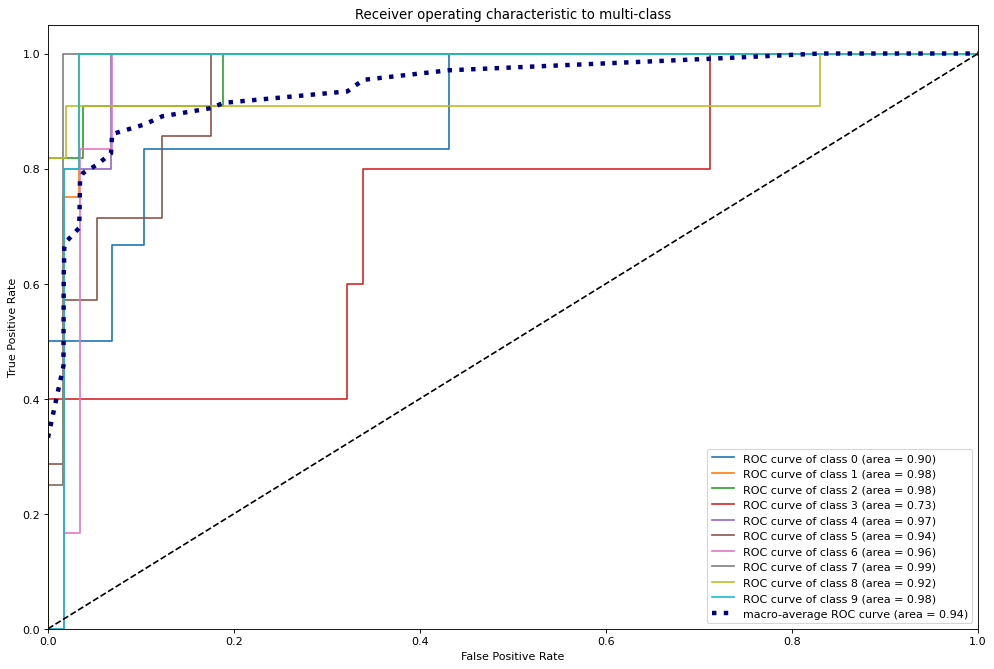

In [27]:
figure(figsize=(15, 10), dpi=80)
plot_rocauc(proba_classes_val_pann, y_valid_vals_pann)

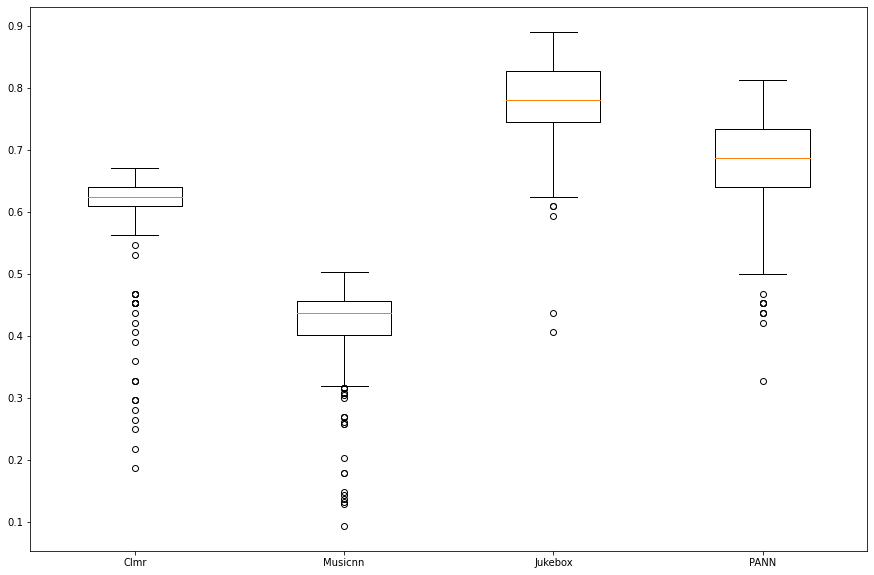

In [28]:
plt.rcParams["figure.figsize"] = (15,10)
plt.boxplot([best_valid_clmr, best_valid_musicnn, best_valid_jukebox, best_valid_pann], labels = ["Clmr","Musicnn","Jukebox","PANN"])
plt.show()